In this notebook, we should the code we used for the \
Section 6 Rask Representation (i.e., finger-printing and identification)
Feature extraction is time consuming and need to download big data from https://reports.alcf.anl.gov/data/.
Here, we have provided extrated feature of 127,585 tasks in 2018 as used in the paper
We also provide a bigger set which covers 372,021 tasks from 2016 to 201904 (task-fingerprint-16to1904.pkl)

Author: Zhengchun Liu

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import glob, operator, time, shutil, scipy, sys, sklearn
import pandas as pd
from sklearn.manifold import TSNE
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

pd.set_option('display.max_columns', 100)
plt.style.use('classic')

In [10]:
features = pd.read_pickle("datasets/autoperf/task-fingerprint.pkl")
features.shape

(127585, 8)

In [12]:
tsne_obj = TSNE(n_components=2, random_state=2019)
# only used the first 45k tasks for quick evaluationa and easier visulaization
X_embedded = tsne_obj.fit_transform(preprocessing.scale(features.values[:45000, :-1])) 
X_embedded.shape, tsne_obj.kl_divergence_, tsne_obj.n_iter_

((45000, 2), 1.504782795906067, 999)

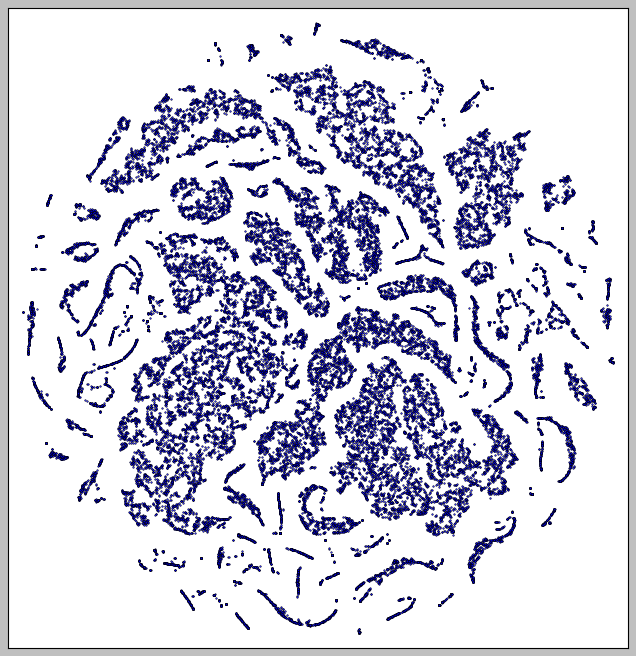

In [45]:
def tsne_vis(X_embed):
    plt.figure(figsize=(10, 10))
    plt.plot(X_embed[:, 0], X_embed[:, 1], 'o', alpha=.8, color='b', markersize=1.5)
    plt.xlim(left=X_embed[:, 0].min()*1.05, right=X_embed[:, 0].max()*1.05)
    plt.ylim(bottom=X_embed[:, 1].min()*1.05, top=X_embed[:, 1].max()*1.05)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    plt.close()

tsne_vis(X_embedded)

sus is marked by g and x
xmfdn-menj_BGQ-lan is marked by b and o
zeltron.exe is marked by gold and >
test_rand_c.x is marked by yellow and <
miniFE.V1R2M4-xl.x is marked by tan and s
rxmd is marked by cyan and v
project_dyn is marked by magenta and H
pibis is marked by black and D
charles.exe is marked by orange and 3
cesm.exe is marked by darkgreen and 1
aims.071914_7.scalapack.mpi.x is marked by g and 2
nwchem-6.6-dft-hf-mp2-only.off is marked by b and x
cpmd_3.17.1.dat is marked by gold and o
dns is marked by yellow and >
qlua-bkend is marked by tan and <
nek5000 is marked by cyan and s
mcfm_omp is marked by magenta and v
qlua is marked by black and H
converge is marked by orange and D
aims.160328_3.scalapack.mpi.x is marked by darkgreen and 3


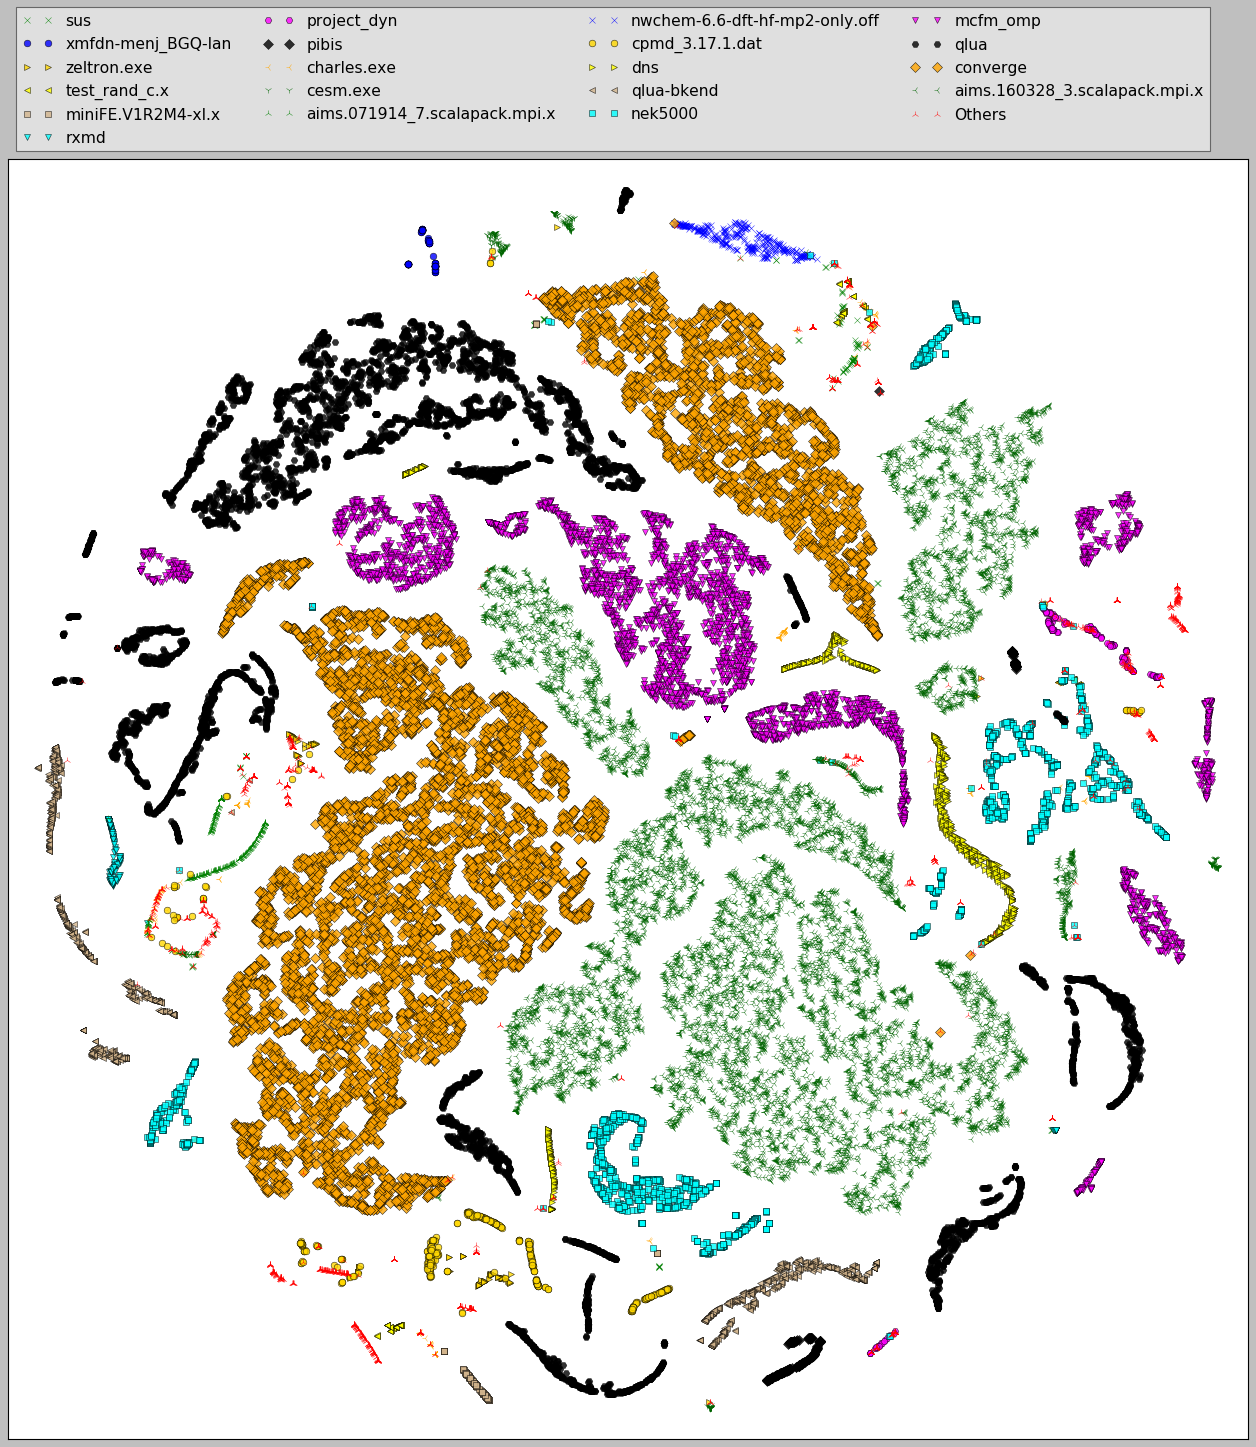

In [41]:
def t_sne_vis_by_group(x_emb, exe_idn, topn=3, ofn=None):
    idn_unique, idn_count = np.unique(exe_idn, return_counts=True)
    top_idn = idn_unique[np.argsort(idn_count)[-topn:]]
    plt.figure(figsize=(20, 20))
    colors = ('g', 'b', 'gold', 'yellow', 'tan', 'cyan', 'magenta', 'black', 'orange', 'darkgreen')
    markers= ('x', 'o', '>', '<', 's', 'v', 'H', 'D', '3', '1', '2')
    _other_grp = np.zeros(exe_idn.shape[0], dtype=np.bool)
    for _idx, _idn in enumerate(top_idn):
        _emb_grp = x_emb[exe_idn == _idn]
        plt.plot(_emb_grp[:, 0], _emb_grp[:, 1], markers[_idx%len(markers)], alpha=.8, color=colors[_idx%len(colors)], markersize=6, label = _idn[:])
        _other_grp |= (exe_idn == _idn)
        print("%s is marked by %s and %s" % (_idn, colors[_idx%len(colors)], markers[_idx%len(markers)]))
    _uncat = x_emb[~_other_grp]
    plt.plot(_uncat[:, 0], _uncat[:, 1], markers[-1], alpha=.8, color='r', markersize=6, label = 'Others')
    
    plt.xlim(left=X_embedded[:, 0].min()*1.05, right=X_embedded[:, 0].max()*1.05)
    plt.ylim(bottom=X_embedded[:, 1].min()*1.05, top=X_embedded[:, 1].max()*1.05)
    plt.xticks([])
    plt.yticks([])
    plt.legend(bbox_to_anchor=(0., 1.0, 1., .1), ncol=4, loc=3, fancybox=False, framealpha=0.5, fontsize=14)
    if ofn is not None:
        plt.savefig('figure/' + ofn, bbox_inches='tight', quality=99, dpi=300)
    plt.show()
    plt.close()

t_sne_vis_by_group(X_embedded, features.values[:45000, -1], topn=20, )

# try to classify application by name

In [32]:
def data_preprocess(feat_df, topn=10):
    tops_labels = feat_df.exec_name.value_counts()[:topn].keys()
    exec_name2id = {}
    for i, x in enumerate(tops_labels):
        exec_name2id[x] = i
    exec_name2id['others'] = topn
    print("top {} executables are labelled as:".format(topn, ))
    for app, idx in exec_name2id.items():
        print("%2d => %s" % (idx, app))
    
    ret_df = feat_df.copy(deep=True) # make a copy
    enc = np.zeros(feat_df.shape[0], dtype=np.int8)
    for i, x in enumerate(feat_df.exec_name.values):
        _enc = exec_name2id.get(x)
        if _enc is None: _enc = exec_name2id['others']
        enc[i] = _enc
        
    ret_df['exec_name'] = enc
    X, Y = ret_df[ret_df.columns[:-1]].astype(np.float), ret_df[ret_df.columns[-1:]].astype(np.int8)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2019)
    return X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = data_preprocess(features, topn=20)

top 20 executables are labelled as:
 0 => aims.160328_3.scalapack.mpi.x
 1 => ks_spectrum_hisq
 2 => qlua
 3 => mcfm_omp
 4 => converge
 5 => distress
 6 => nek5000
 7 => dns
 8 => qlua-bkend
 9 => project_dyn
10 => xmfdn-menj_BGQ-lan
11 => rwalk
12 => aims.071914_7.scalapack.mpi.x
13 => wrf.exe
14 => cpmd_3.17.1.dat
15 => nwchem-6.6-dft-hf-mp2-only.off
16 => vof.exe
17 => cesm.exe
18 => rwalk-xpoff
19 => miniFE.V1R2M4-xl.x
20 => others


In [25]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=2019, max_depth=10)
xgb_model.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=2019,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [26]:
y_pred = xgb_model.predict(X_test)
y_true = y_test.values.ravel()

In [28]:
print('Accuracy: %.4f, F1 score: %.4f' % (metrics.accuracy_score(y_true, y_pred), metrics.f1_score(y_true, y_pred, average='macro')))

Accuracy: 0.9914, F1 score: 0.9601


In [29]:
print(metrics.classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8112
           1       1.00      1.00      1.00      5696
           2       1.00      1.00      1.00      5598
           3       1.00      1.00      1.00      5432
           4       1.00      1.00      1.00      4034
           5       1.00      1.00      1.00      1781
           6       0.98      0.97      0.97      1231
           7       1.00      1.00      1.00       870
           8       1.00      1.00      1.00       816
           9       0.90      0.94      0.92       775
          10       1.00      1.00      1.00       435
          11       0.85      0.88      0.87       349
          12       1.00      1.00      1.00       293
          13       1.00      0.99      1.00       233
          14       0.99      0.94      0.96       158
          15       1.00      0.99      0.99       182
          16       0.97      0.99      0.98       143
          17       1.00    

It seems that the calssifier did not do a good job for application _rwalk-xpoff_
Fine tune model hyper-parameter should help.